* Training notebook.
* You would need to submit result in the separate one.
* Unfortunately, I can't reproduce my training -> maybe you would be more lucky...

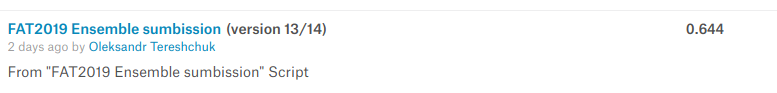

### imports

In [ ]:
import gc
import os
import pickle
import random
import time
from collections import Counter, defaultdict
from operator import itemgetter
from functools import partial
from pathlib import Path
from psutil import cpu_count

import numpy as np
import pandas as pd

import librosa
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

from fastprogress import master_bar, progress_bar

### utils

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 666
seed_everything(SEED)

In [ ]:
N_JOBS = cpu_count()
os.environ['MKL_NUM_THREADS'] = str(N_JOBS)
os.environ['OMP_NUM_THREADS'] = str(N_JOBS)
DataLoader = partial(DataLoader, num_workers=N_JOBS)

In [ ]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

### dataset

In [ ]:
dataset_dir = Path('../input/freesound-audio-tagging-2019')
preprocessed_dir = Path('../input/fat2019_prep_mels1')

In [ ]:
csvs = {
    'train_curated': dataset_dir / 'train_curated.csv',
    #'train_noisy': dataset_dir / 'train_noisy.csv',
    'train_noisy': preprocessed_dir / 'trn_noisy_best50s.csv',
    'sample_submission': dataset_dir / 'sample_submission.csv',
}

dataset = {
    'train_curated': dataset_dir / 'train_curated',
    'train_noisy': dataset_dir / 'train_noisy',
    'test': dataset_dir / 'test',
}

mels = {
    'train_curated': preprocessed_dir / 'mels_train_curated.pkl',
    'train_noisy': preprocessed_dir / 'mels_trn_noisy_best50s.pkl',
    'test': preprocessed_dir / 'mels_test.pkl',  # NOTE: this data doesn't work at 2nd stage
}

In [ ]:
train_curated = pd.read_csv(csvs['train_curated'])
train_noisy = pd.read_csv(csvs['train_noisy'])
train_df = train_curated #pd.concat([train_curated, train_noisy], sort=True, ignore_index=True)
#train_df.head()

In [ ]:
test_df = pd.read_csv(csvs['sample_submission'])
#test_df.head()

In [ ]:
labels = test_df.columns[1:].tolist()
#labels

In [ ]:
num_classes = len(labels)
#num_classes

In [ ]:
y_train = np.zeros((len(train_df), num_classes)).astype(int)
for i, row in enumerate(train_df['labels'].str.split(',')):
    for label in row:
        idx = labels.index(label)
        y_train[i, idx] = 1

y_train.shape

In [ ]:
# with open(mels['train_curated'], 'rb') as curated, open(mels['train_noisy'], 'rb') as noisy:
#     x_train = pickle.load(curated)
#     x_train.extend(pickle.load(noisy))
with open(mels['train_curated'], 'rb') as curated:
    x_train = pickle.load(curated)

with open(mels['test'], 'rb') as test:
    x_test = pickle.load(test)
    
len(x_train), len(x_test)

In [ ]:
class FATTrainDataset(Dataset):
    def __init__(self, mels, labels, transforms, crop=True):
        super().__init__()
        self.mels = mels
        self.labels = labels
        self.transforms = transforms
        self.crop = crop
        
    def __len__(self):
        return len(self.mels)
    
    def __getitem__(self, idx):
        image = Image.fromarray(self.mels[idx], mode='RGB')      

        if self.crop:
            time_dim, base_dim = image.size
            crop = random.randint(0, time_dim - base_dim)
            image = image.crop([crop, 0, crop + base_dim, base_dim])

        image = self.transforms(image).div_(255)
        
        label = self.labels[idx]
        label = torch.from_numpy(label).float()
        
        return image, label

In [ ]:
class FATTestDataset(Dataset):
    def __init__(self, fnames, mels, transforms):
        super().__init__()
        self.fnames = fnames
        self.mels = mels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        new_idx = idx % len(self.fnames)
        
        image = Image.fromarray(self.mels[new_idx], mode='RGB')
        image = self.transforms(image).div_(255)

        fname = self.fnames[new_idx]
        
        return image, fname

In [ ]:
transforms_dict = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        #transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
    ]),
}

### model

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x_conv1 = self.conv1(x)
        x = self.conv2(x_conv1)
        x = F.avg_pool2d(x + x_conv1, 2)
        return x

In [ ]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)
        return x

In [ ]:
Classifier(num_classes=num_classes)

### train

In [ ]:
test_image = Image.fromarray(x_train[0], mode='RGB')
print(test_image.size)
test_image

In [ ]:
del test_image

In [ ]:
import math
import torch
from torch.optim import Optimizer


class AdamW(Optimizer):
    """Implements AdamW algorithm.

    It has been proposed in `Fixing Weight Decay Regularization in Adam`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)

    .. Fixing Weight Decay Regularization in Adam:
    https://arxiv.org/abs/1711.05101
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        super(AdamW, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('AdamW does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # according to the paper, this penalty should come after the bias correction
                # if group['weight_decay'] != 0:
                #     grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

                if group['weight_decay'] != 0:
                    p.data.add_(-group['weight_decay'], p.data)

        return loss

In [ ]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
def train_model(x_trn, x_val, y_trn, y_val, train_transforms, model, num_epochs=100, lr=1e-3, batch_size=71, fine_tune=False, weight_file_name='weight_best.pt'):
    test_batch_size = 1
    eta_min = 1e-6
    t_max = 10
    mixup_alpha = 1.0
    
    num_classes = y_train.shape[1]
    
    train_dataset = FATTrainDataset(x_trn, y_trn, train_transforms)
    valid_dataset = FATTrainDataset(x_val, y_val, train_transforms, crop=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=test_batch_size, shuffle=False)

    criterion = nn.BCEWithLogitsLoss().cuda()
    optimizer = AdamW(params=model.parameters(), lr=lr, weight_decay=lr/10)
    if fine_tune:
        scheduler = ReduceLROnPlateau(optimizer, mode='min')
    else:
        scheduler = CosineAnnealingLR(optimizer, T_max=t_max, eta_min=eta_min)
    

    best_epoch = -1
    best_lwlrap = 0.

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        avg_loss = 0.

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()
            
            x_batch, targets_a, targets_b, lam = mixup_data(x_batch, y_batch, mixup_alpha)
            x_batch, targets_a, targets_b = map(Variable, (x_batch, targets_a, targets_b))

            preds = model(x_batch)
            loss = mixup_criterion(criterion, preds, targets_a, targets_b, lam)
            #loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_loss += loss.item() / len(train_loader)

        model.eval()
        valid_preds = np.zeros((len(x_val), num_classes))
        avg_val_loss = 0.

        for i, (x_batch, y_batch) in enumerate(valid_loader):
            preds = model(x_batch.cuda()).detach()
            loss = criterion(preds, y_batch.cuda())

            preds = torch.sigmoid(preds)
            valid_preds[i * test_batch_size: (i+1) * test_batch_size] = preds.cpu().numpy()

            avg_val_loss += loss.item() / len(valid_loader)
            
        score, weight = calculate_per_class_lwlrap(y_val, valid_preds)
        lwlrap = (score * weight).sum()
        
        log_epoch = epoch % 5 == 0
        if lwlrap > best_lwlrap:
            log_epoch = True
            best_epoch = epoch + 1
            best_lwlrap = lwlrap
            torch.save(model.state_dict(), weight_file_name)
            
        if log_epoch:
            elapsed = time.time() - start_time
            print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  val_lwlrap: {lwlrap:.6f}  time: {elapsed:.0f}s')
            
        if fine_tune:
            scheduler.step(avg_val_loss)
        else:
            scheduler.step()
            
    return {
        'best_epoch': best_epoch,
        'best_lwlrap': best_lwlrap,
        'weight_file_name' : weight_file_name,
    }

In [ ]:
def pick_best_result(result1, result2):
    if result2['best_lwlrap'] > result1['best_lwlrap']:
        return result2
    else:
        return result1

In [ ]:
test_loader = DataLoader(FATTestDataset(test_df['fname'], x_test, transforms_dict['test']), batch_size=1, shuffle=False)

kf = KFold(n_splits=5, random_state=SEED, shuffle=True)
predictions = []
results = []
for train_index, test_index in kf.split(np.arange(len(train_df))):
    fold = str(len(predictions) + 1)
    
    x_trn = list(itemgetter(*train_index)(x_train))
    y_trn = np.array(list(itemgetter(*train_index)(y_train)))
    
    x_val = list(itemgetter(*test_index)(x_train))
    y_val = np.array(list(itemgetter(*test_index)(y_train)))
    
    model = Classifier(num_classes=num_classes).cuda()
    result1 = train_model(x_trn, x_val, y_trn, y_val, transforms_dict['train'], model.cuda(), num_epochs=75, batch_size=10, weight_file_name=fold + 'weight_best.pt')
    print("Rough annealing:")
    print(result1)

    model = Classifier(num_classes=num_classes)
    model.load_state_dict(torch.load(result1['weight_file_name']))
    result2 = train_model(x_trn, x_val, y_trn, y_val, transforms_dict['train'], model.cuda(), num_epochs=35, lr=4e-4, weight_file_name=fold + 'weight_best_tune_stage1.pt')
    print("Fine annealing:")
    print(result2)

    best_result = pick_best_result(result1, result2)

    model = Classifier(num_classes=num_classes)
    model.load_state_dict(torch.load(best_result['weight_file_name']))
    result3 = train_model(x_trn, x_val, y_trn, y_val, transforms_dict['train'], model.cuda(), lr=5e-5, num_epochs=60, fine_tune=True, weight_file_name=fold + 'weight_best_tune_stage2.pt')
    print("Fine tuning:")
    print(result3)

    best_result = pick_best_result(best_result, result3)
    results.append(best_result)
    model = Classifier(num_classes=num_classes)
    model.load_state_dict(torch.load(best_result['weight_file_name']))
    model.cuda()
    model.eval()
    
    all_outputs = []
    for images, _ in test_loader:
        preds = torch.sigmoid(model(images.cuda()).detach())
        all_outputs.append(preds.cpu().numpy())
    fold_preds = np.concatenate(all_outputs)
    predictions.append(fold_preds)

In [ ]:
test_df[labels] = np.mean(np.array(predictions), axis=0)
test_df.to_csv('submission_mean.csv', index=False)
test_df.head()

### predict

In [ ]:
def predict_model(test_fnames, x_test, test_transforms, num_classes, model):
    batch_size = 1

    test_dataset = FATTestDataset(test_fnames, x_test, test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.cuda()
    model.eval()

    all_outputs, all_fnames = [], []

    pb = progress_bar(test_loader)
    for images, fnames in pb:
        preds = torch.sigmoid(model(images.cuda()).detach())
        all_outputs.append(preds.cpu().numpy())
        all_fnames.extend(fnames)

    test_preds = pd.DataFrame(data=np.concatenate(all_outputs),
                              index=all_fnames,
                              columns=map(str, range(num_classes)))
    test_preds = test_preds.groupby(level=0).mean()

    return test_preds

In [ ]:
def lwlrap_key(result):
    return result['best_lwlrap']

In [ ]:
best_result = max(results, key=lwlrap_key)
print(best_result)

model = Classifier(num_classes=num_classes)
model.load_state_dict(torch.load(best_result['weight_file_name']))
model.cuda()
model.eval()

test_preds = predict_model(test_df['fname'], x_test, transforms_dict['test'], num_classes, model)
test_df[labels] = test_preds.values
test_df.to_csv('submission.csv', index=False)
test_df.head()